In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pdb

In [2]:
import os 
import data
import maml
import regressors

In [9]:
gen = data.SinusoidGenerator(batch_size = 16,
                 num_tasks = 1024,
                 x_range = (-5, 5),
                 A_range = (0.1, 5),
                 P_range = (0, np.pi),
                 max_train_points=10,
                 max_test_points=10)

In [4]:
task = gen.generate_task()

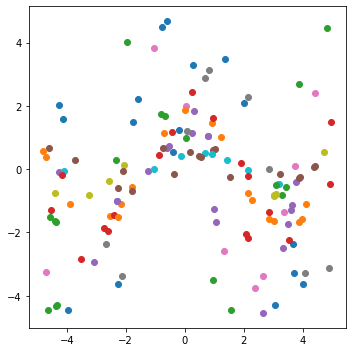

In [6]:
#fig, axes = plt.subplots(3,3,figsize=(20,15))
fig = plt.figure(figsize=(5,5))
for idx in range(task['x'].shape[0]):
    x = task['x'][idx,:,:]
    y = task['y'][idx,:,:]
    plt.plot(x,y,'o')
    #ax.title.set_text(idx)
    #ax.set_xlim(-5,5)
    plt.tight_layout()

In [10]:
model = regressors.MLP(in_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

meta_model = maml.MAML_trainer(model, optimizer)

In [11]:
for idx, task in enumerate(gen):
    if (idx % 100) == 0:
        print(idx)
    meta_model.outer_loop_train(task['x_context'],
                          task['y_context'],
                          task['x_target'],
                          task['y_target'])

0
100
200
300
400
500
600
700
800
900
1000


In [ ]:
import copy